# Notebook Structure Overview:


## Part 1: Data Preprocessing
 --------------------------
- Loading data from the drive.
- Preprocessing the data to be suitable for LSTM model input, including scaling, normalization

## Part 2: Model Training
 ----------------------
 - Defining an LSTM model architecture suitable for time series forecasting of network traffic.
-  Training the LSTM model using historical data of transfer traffic and network throughput.

## Part 3: Model Testing
 ---------------------
 - Testing the trained LSTM model by performing predictions on the test set.
 - Evaluating the model's performance using Mean Absolute Error

## Part 4: PID Integration for Prediction Improvement
 --------------------------------------------------
- Integrating a PID controller to refine the predictions made by the LSTM model.
- Adjusting the PID parameters (Ki, Kp, Kd) to minimize prediction error, potentially enhancing accuracy.


# Importing necessary libraries below

In [2]:

import os
import math
import numpy as np
import pandas as pd
from pandas import read_csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM,GRU, Dropout, Lambda, Bidirectional, BatchNormalization
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, Adadelta, Nadam
from keras import regularizers, backend as K, utils
from keras.regularizers import Regularizer
from keras.utils import register_keras_serializable
from google.colab import drive
from datetime import datetime

# fixing random seed for reproducibility
seed = 2022
np.random.seed(seed)

# Part 1: Connecting to the drive to access the data

In [3]:
# Mounting Google Drive to access files
drive.mount('/content/gdrive')
Increasing_BW_data = pd.read_fwf('/content/gdrive/My Drive/Data/Increasing_BW.txt')
Increasing_BW_data_2 = pd.read_fwf('/content/gdrive/My Drive/Increase_in_BW_data2.txt') # more noisy data


Mounted at /content/gdrive


# Steps below are performing some data_preprocessing

In [4]:
datasets = [Increasing_BW_data,Increasing_BW_data_2 ]

In [5]:
# Defining a function to apply the operation for removing strings from the data
def extract_and_convert_to_float(df):
    for column in df.columns:
      if pd.api.types.is_string_dtype(df[column]):
        df[column] = df[column].str.extract(r'(\d+[.\d]*)').astype(float)
    return df

for df in datasets:
    df = extract_and_convert_to_float(df)

In [6]:
# Dropping off irrelevant columns and only keeping the relevant
data_frames = [Increasing_BW_data,Increasing_BW_data_2]
for df in data_frames:
   df.drop(columns=df.columns.difference(['Transfer', 'Bandwidth']), inplace=True)

In [7]:
# Removing outlier points (0)
Increasing_BW_data_2 = Increasing_BW_data_2[Increasing_BW_data_2['Transfer'] != 0]

In [8]:
# Adding an extra column to help in ploting and visualization
Increasing_BW_data_2['increment'] = range(len(Increasing_BW_data_2))

<ipython-input-8-a64f92c9b77d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Increasing_BW_data_2['increment'] = range(len(Increasing_BW_data_2))


In [9]:
# Dividing 'Transfer' column values by 1024 for data conversion to MBytes
Increasing_BW_data.loc[0:38, 'Transfer'] /= 1024

In [10]:
# Dividing 'Transfer' column values by 1024 for data conversion to MBytes
Increasing_BW_data_2.loc[Increasing_BW_data_2['Transfer'] > 50, 'Transfer'] = Increasing_BW_data_2['Transfer'] / 1024

In [11]:
# Since the BW increased to Gbps, we Multiply some values by 1000 where the value is less than 5 to make uniformity of Mbps
Increasing_BW_data.loc[Increasing_BW_data['Bandwidth'] < 5, 'Bandwidth'] *= 1000

In [12]:
# Further dropping off outlier points
Increasing_BW_data.drop([1159, 3980], inplace=True)

# Visualizing the noisy traffic we shall make predictions on

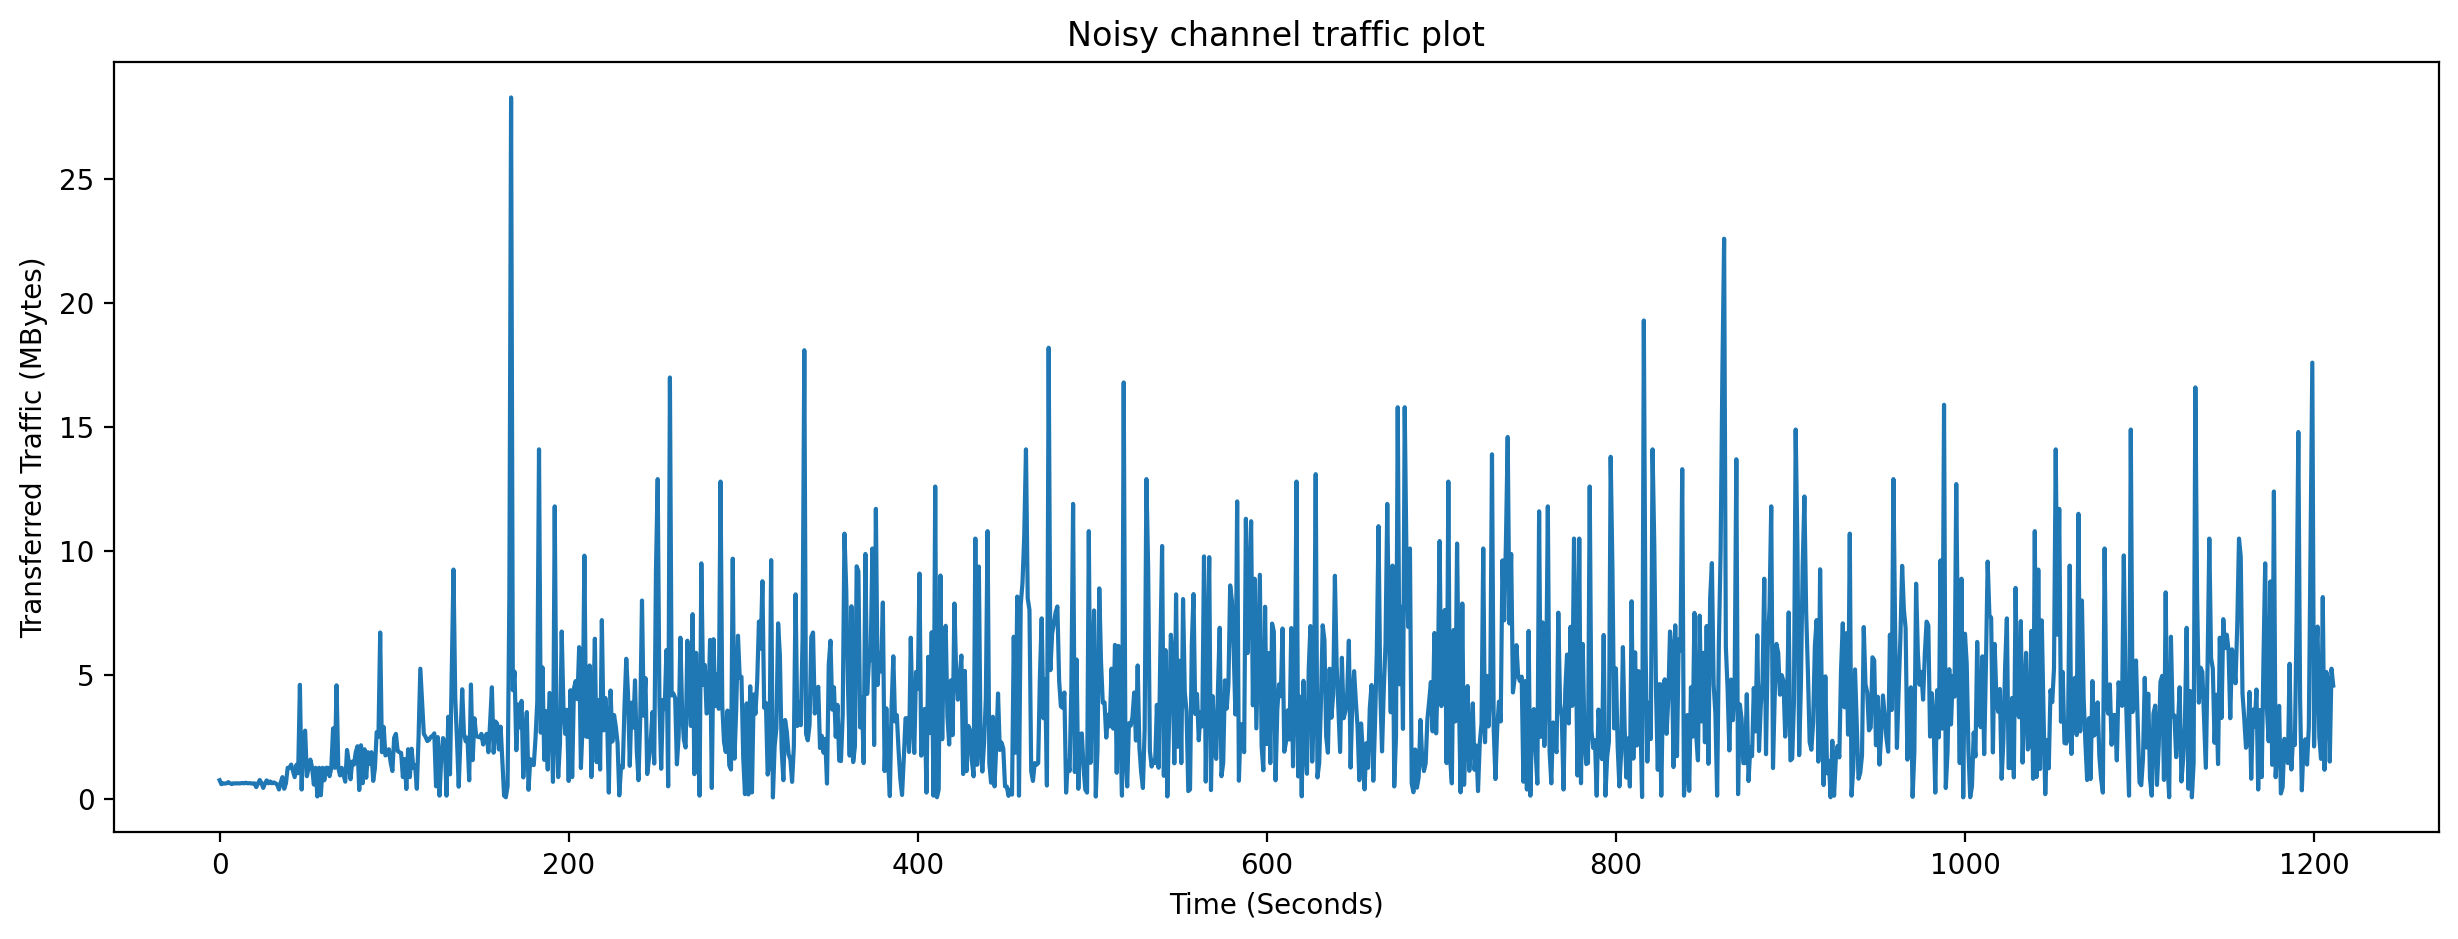

In [13]:
import seaborn as sns
# Creating a plot to visualize the data
plt.figure(figsize=(15, 5), dpi=200)
sns.lineplot(x='increment', y='Transfer', data=Increasing_BW_data_2)
plt.xlabel('Time (Seconds)')
plt.title('Noisy channel traffic plot')
plt.ylabel('Transferred Traffic (MBytes)')
plt.show()

# Perfoming data splitting (Training_set, Validation_set, Test_set)

In [14]:
# Defining train_size as 70% of the length of the data
train_size = int(0.7 * len(Increasing_BW_data))
# Creating the train_set by selecting the first 70% of the data
train_set = Increasing_BW_data[:train_size]

In [15]:
# Defining validation_size as 15% of the length of the data
val_size = int(0.15 * len(Increasing_BW_data))
# Creating the val_set by selecting the first 15% of the data
val_set = Increasing_BW_data[train_size:train_size + val_size]

# Here, the test_set is the new noisy traffic which we shall perform predictions on

In [16]:
test_set = Increasing_BW_data_2

In [17]:
# Concatenating train_set and val_set to create train_all_data
train_all = pd.concat([train_set, val_set], axis=0)

In [18]:
# Extracting data from dataframes, selecting the features
# The labels simply contain the Transferred Trafic

#  Selecting which features to use:

def feature_matrix(df,features):
    numsamples = df.shape[0]
    numfeatures = len(features)

    fm = np.zeros((numsamples,numfeatures))
    for idx in range(numfeatures):
        fm[:,idx] = df[features[idx]]
    return fm

features = ['Bandwidth', 'Transfer']

# Important: Tensorflow 2.x gives an error omitting
# the np.asarray(...,,dtype=np.float32)

# trainining  and validation data
train_values = np.asarray(feature_matrix(train_set,features),dtype=np.float32)
train_labels = np.asarray(train_set['Transfer'],dtype=np.float32)

val_values = np.asarray(feature_matrix(val_set,features),dtype=np.float32)
val_labels = np.asarray(val_set['Transfer'],dtype=np.float32)

# train_all_data for retraining before testing
train_all_values = np.asarray(feature_matrix(train_all,features),dtype=np.float32)
train_all_labels = np.asarray(train_all['Transfer'],dtype=np.float32)

# test data
test_values = np.asarray(feature_matrix(test_set,features),dtype=np.float32)
test_labels = np.asarray(test_set['Transfer'],dtype=np.float32)



# checking
print(train_values.shape)
print(train_labels.shape)

print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)

(3915, 2)
(3915,)
(838, 2)
(838,)
(4753, 2)
(4753,)
(1212, 2)
(1212,)


In [19]:
# Creating a MinMaxScaler instance SS1 and fitting it to train_values
SS1 = MinMaxScaler()
SS1.fit(train_values)

# Transforming train_values and val_values using SS1
train_scaled = SS1.transform(train_values)
val_scaled = SS1.transform(val_values)

# Creating another MinMaxScaler instance SS2 and fitting it to train_all_values
SS2 = MinMaxScaler()
SS2.fit(train_all_values)

# Transforming train_all_values and test_values using SS2
train_all_scaled = SS2.transform(train_all_values)
test_scaled = SS2.transform(test_values)

# Setting the desired WINDOW_SIZE

In [20]:
WINDOW_SIZE = 1

In [46]:
# Function to create our windowed dataset
def create_dataset_windowed(features, labels, ahead=120, window_size=WINDOW_SIZE, max_window_size=200):
    samples = features.shape[0]-ahead-(max_window_size-1)
    window_size = min(max(window_size,1),max_window_size)

    dataX = []
    for i in range(samples):
        a = features[(i+max_window_size-window_size):(i+max_window_size), :]
        dataX.append(a)
    return np.array(dataX), labels[ahead+max_window_size-1:]

Creating the windowed data_sets for training and validation

In [97]:
X_train_dense, r_train_dense = create_dataset_windowed(train_scaled, train_labels)
X_val_dense, r_val_dense = create_dataset_windowed(val_scaled, val_labels)

# Printing shapes of the created datasets
print(X_train_dense.shape)
print(r_train_dense.shape)
print(X_val_dense.shape)
print(r_val_dense.shape)


(3714, 1, 2)
(3714,)
(637, 1, 2)
(637,)


# Part 2: First training the model on the training and validation sets

In [101]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer in the RNN to 256
HIDDEN_RNN = 256
# regularization
wreg = L1L2(l1=0.001, l2=0.01)

LSTMmodel = Sequential()

# Adding layers to the model
LSTMmodel.add(Dense(32, input_shape=(WINDOW_SIZE,2), activation='relu'))
LSTMmodel.add(LSTM(input_shape = (WINDOW_SIZE,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTMmodel.add(Dense(16,activation='relu'))
LSTMmodel.add(Dense(8,activation='relu'))
LSTMmodel.add(Dense(4,activation='relu'))
LSTMmodel.add(Dense(1))
LSTMmodel.summary()

LSTMmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=16
epochs=40

# Training the model
LSTMhistory = LSTMmodel.fit(X_train_dense, r_train_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_dense, r_val_dense),
          shuffle=True)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_50 (Dense)            (None, 1, 32)             96        
                                                                 
 lstm_10 (LSTM)              (None, 256)               295936    
                                                                 
 dense_51 (Dense)            (None, 16)                4112      
                                                                 
 dense_52 (Dense)            (None, 8)                 136       
                                                                 
 dense_53 (Dense)            (None, 4)                 36        
                                                                 
 dense_54 (Dense)            (None, 1)                 5         
                                                                 
Total params: 300321 (1.15 MB)
Trainable params: 3003

In [102]:
# Plotting the history of Mean Absolute Error for training and validation sets
def plot_history(history):
  plt.figure(figsize = (6,4))

  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

# Plotting the training and validation loss curves

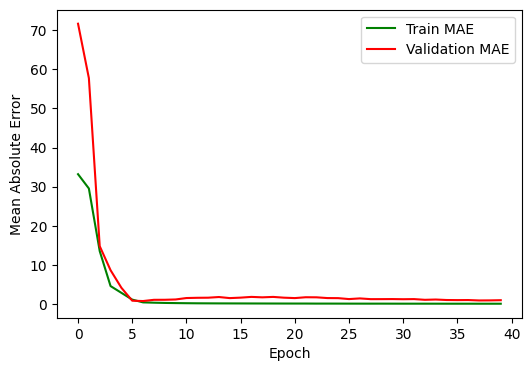

In [103]:
plot_history(LSTMhistory)

In [47]:
# Creating a windowed data_set on the train_all and test_data
X_train_all_dense,r_train_all_dense = create_dataset_windowed(train_all_scaled,train_all_labels)
X_test_dense,r_test_dense = create_dataset_windowed(test_scaled,test_labels)

print(X_train_all_dense.shape)
print(r_train_all_dense.shape)
print(X_test_dense.shape)
print(r_test_dense.shape)

(4434, 1, 2)
(4434,)
(893, 1, 2)
(893,)


# Part 2: Training the model on the whole training set (train + validation sets) and evaluating it on the test set.

In [48]:
from tensorflow.keras.regularizers import L1L2
# Setting the number of units for the hidden layer  to 256
HIDDEN_RNN = 256
# applying regularization
wreg = L1L2(l1=0.001, l2=0.01)

LSTM_model = Sequential()

# Adding layers to the model
LSTM_model.add(Dense(32, input_shape=(WINDOW_SIZE,2), activation='relu'))
LSTM_model.add(LSTM(input_shape = (WINDOW_SIZE,2),
                   units=HIDDEN_RNN,
                   return_sequences=False,
                   kernel_regularizer=wreg))

LSTM_model.add(Dense(16,activation='relu'))
LSTM_model.add(Dense(8,activation='relu'))
LSTM_model.add(Dense(4,activation='relu'))
LSTM_model.add(Dense(1))
LSTM_model.summary()

LSTM_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='mae', metrics=['mae','mse'])

batch_size=8
epochs=40

# Training the model
LSTM_history = LSTM_model.fit(X_train_all_dense, r_train_all_dense,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_test_dense, r_test_dense),
          shuffle=True)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 1, 32)             96        
                                                                 
 lstm_2 (LSTM)               (None, 256)               295936    
                                                                 
 dense_11 (Dense)            (None, 16)                4112      
                                                                 
 dense_12 (Dense)            (None, 8)                 136       
                                                                 
 dense_13 (Dense)            (None, 4)                 36        
                                                                 
 dense_14 (Dense)            (None, 1)                 5         
                                                                 
Total params: 300321 (1.15 MB)
Trainable params: 30032

In [49]:
# Plotting the history of Mean Absolute Error for training_all_dataset and test sets
def plot_history_test(history):
  plt.figure(figsize = (6,4), dpi=200)
  plt.xlabel('Epoch')
  plt.ylabel('Mean Absolute Error')
  plt.title(' Model Training Loss Curves')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Training MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Test MAE')
  plt.legend()
  plt.show()

# Plotting the model loss curves

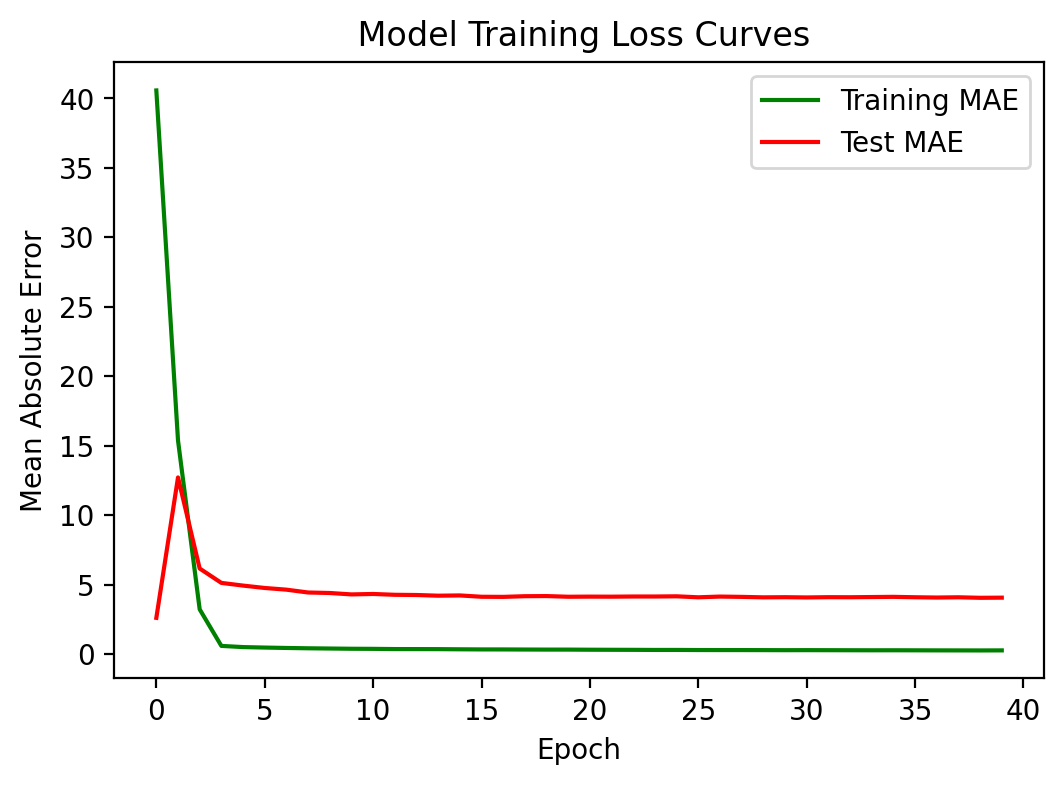

In [50]:
plot_history_test(LSTM_history)

# Performing evaluation using MAE

In [51]:
from sklearn.metrics import mean_absolute_error
# Making predictions using the trained model
y_train_all_LSTM = LSTM_model.predict(X_train_all_dense)
y_test_LSTM = LSTM_model.predict(X_test_dense)

# Calculating the mean absolute error from the training_all_dataset and test sets
mae_train_all_LSTM = mean_absolute_error(r_train_all_dense, y_train_all_LSTM)
mae_test_LSTM = mean_absolute_error(r_test_dense, y_test_LSTM)

# Printing the mean absolute error from the training_all_dataeet and test sets
print("\ train_all mae = ", mae_train_all_LSTM,
      "\n Test mae = ", mae_test_LSTM)

# Checking the shapes of the predicted output from the training_all_dataset and test sets
print(y_train_all_LSTM.shape)
print(y_test_LSTM.shape)

28/28 [==============================] - 0s 3ms/step
\ train_all mae =  0.2425846 
 Test mae =  4.057464
(4434, 1)
(893, 1)


# Part 4: PID Integration to improve on predictions

In [52]:
# Initializing the PID controller
class PIDController:
    def __init__(self, Kp, Ki, Kd):
        """
        Parameters:
        - Kp (float): Proportional gain coefficient.
        - Ki (float): Integral gain coefficient.
        - Kd (float): Derivative gain coefficient.
        """
        self.Kp = Kp
        self.Ki = Ki
        self.Kd = Kd
        self.prev_error = 0 # Previous error initialized to zero
        self.integral = 0 # Integral term initialized to zero

    def compute_control_signal(self, error):
        """
        Computing the control signal based on the current error.

        Parameters:
        - error (float): The current error signal.

        Returns:
        - control_signal (float): The computed control signal.
        """
        self.integral += error
        derivative = error - self.prev_error
        self.prev_error = error
        control_signal = self.Kp * error + self.Ki * self.integral + self.Kd * derivative # Computing the control signal using PID formula
        return control_signal

# Defining PID parameters
Kp = 0.5
Ki = 0.001
Kd = 0.5

# Initializing the PID controller
pid_controller = PIDController(Kp, Ki, Kd)

# Setting reference values
reference_train = r_train_all_dense
reference_test = r_test_dense

# Initializing PID control signals
control_signal_train = 0
control_signal_test = 0

y_train_all_LSTM_new = []
y_test_LSTM_new = []

# PID control loop
for i in range(len(X_train_all_dense)):
    error_train = reference_train[i] - y_train_all_LSTM[i]
    control_signal_train = pid_controller.compute_control_signal(error_train)
    # Applying control signal to model output
    y_train_all_LSTM_new.append(y_train_all_LSTM[i] + control_signal_train)

for i in range(len(X_test_dense)):
    error_test = reference_test[i] - y_test_LSTM[i]
    control_signal_test = pid_controller.compute_control_signal(error_test)
    # Applying control signal to model output
    y_test_LSTM_new.append(y_test_LSTM[i] + control_signal_test)


# PID Mean Absolute Error
mae_train_all_LSTM_new = mean_absolute_error(reference_train, y_train_all_LSTM_new)
mae_test_LSTM_new = mean_absolute_error(reference_test, y_test_LSTM_new)

# printing MAE results for comparison
print(f"Old MAE for train: {mae_train_all_LSTM}")
print(f"Old MAE for test: {mae_test_LSTM}")
print(f"New(PID) MAE for train: {mae_train_all_LSTM_new}")
print(f"New(PID) MAE for test: {mae_test_LSTM_new}")


Old MAE for train: 0.24258460104465485
Old MAE for test: 4.057464122772217
New(PID) MAE for train: 0.15203426778316498
New(PID) MAE for test: 1.869641661643982


# Plotting the predictions

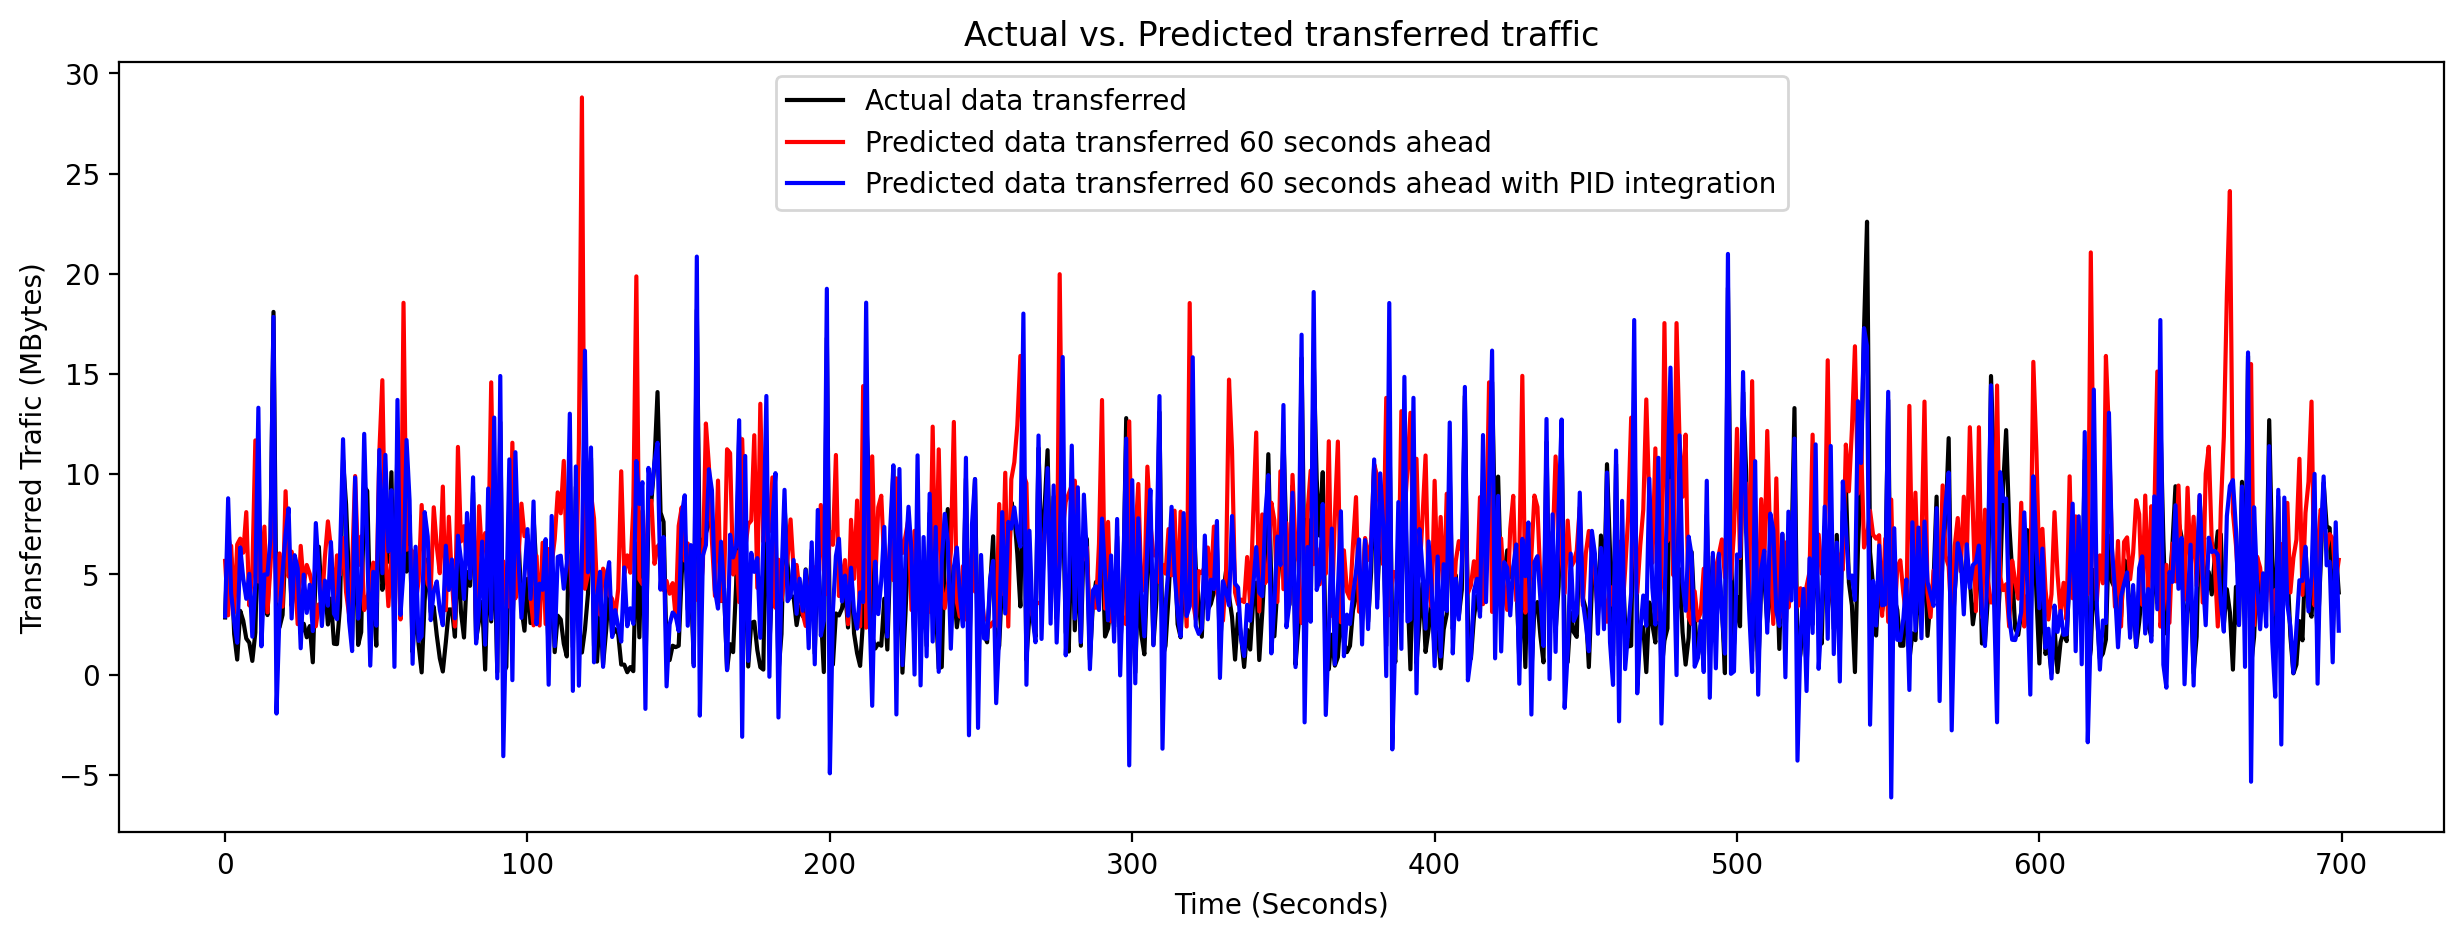

In [54]:
# Now plotting the labels and scaled predictions

plt.figure(figsize=(15, 5), dpi=200)
plt.plot(r_test_dense[:700], 'k-', label='Actual data transferred')
plt.plot(y_test_LSTM[:700], 'r-', label='Predicted data transferred 60 seconds ahead')
plt.plot(y_test_LSTM_new[:700], 'b-', label='Predicted data transferred 60 seconds ahead with PID integration')
plt.ylabel('Transferred Trafic (MBytes)')
plt.xlabel('Time (Seconds)')
plt.title('Actual vs. Predicted transferred traffic')
plt.legend()
plt.show()

# Displaying a table for the plotted predictions for visualization

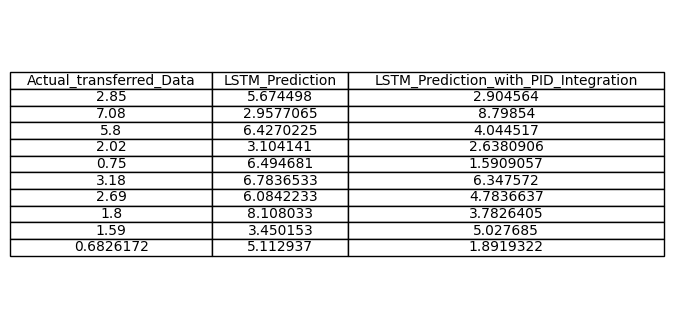

In [55]:
# Extracting values from index 0 to 10 for display in a table
r_test_dense_selected = np.array(r_test_dense[0:10])
y_test_LSTM_selected = np.array(y_test_LSTM[0:10])
y_test_LSTM_new_selected = np.array(y_test_LSTM_new[0:10])

# Flattenning the arrays
r_test_dense_1d = r_test_dense_selected.flatten()
y_test_LSTM_1d = y_test_LSTM_selected.flatten()
y_test_LSTM_new_1d = y_test_LSTM_new_selected.flatten()

# Creating DataFrame
data_pred = {
    'Actual_transferred_Data': r_test_dense_1d,
    'LSTM_Prediction': y_test_LSTM_1d,
    'LSTM_Prediction_with_PID_Integration': y_test_LSTM_new_1d
}
df_pred = pd.DataFrame(data_pred)

# Creating figure and axis
fig, ax = plt.subplots(figsize=(8, 4))

ax.axis('tight')
ax.axis('off')

# Creating the display table
table = ax.table(cellText=df_pred.values,
                 colLabels=df_pred.columns,
                 cellLoc='center',
                 loc='center')

# Setting font size
table.auto_set_font_size(False)
table.set_fontsize(10)

# Adjusting cell heights
table.auto_set_column_width(col=list(range(len(df_pred.columns))))
table.auto_set_column_width(-1)

# Showing table
plt.show()


# Plotting the the average error for comparison

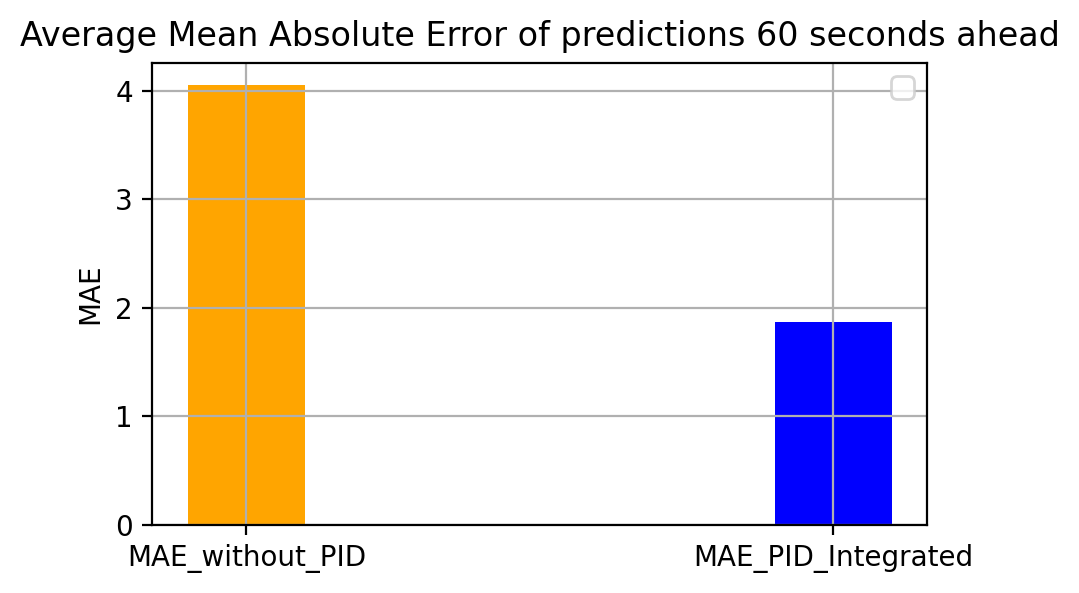

In [57]:
values = {'MAE_without_PID': mae_test_LSTM, 'MAE_PID_Integrated': mae_test_LSTM_new}
colors = ['orange', 'blue']
bar_width = 0.2
plt.figure(figsize=(5, 3), dpi=200)

# Plotting
plt.bar(values.keys(), values.values(), color=colors, width=bar_width)
x_pos = list(range(len(values)))

# Adding labels and title
plt.ylabel('MAE')
plt.title('Average Mean Absolute Error of predictions 60 seconds ahead')
plt.xticks(x_pos, values.keys())
plt.legend()
plt.grid(True)
# Showing the plot
plt.show()